# VAE

In [2]:
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import TensorDataset
from torch import optim
from torch.utils.data import DataLoader

from VAE import VariationalAutoencoder, loss_fun

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_data(train_ds, valid_ds, bs):
    # returns dataloaders for the training and validation sets.
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [4]:
%autoreload
mnist = datasets.MNIST('../mnist_data', train=True, download=False)

train_data = TensorDataset(mnist.train_data.float()/255, mnist.train_data.float()/255)
validation_data = TensorDataset(mnist.test_data.float()/255, mnist.test_data.float()/255)
train_dl, validation_dl = get_data(train_data, validation_data, 32)

/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [5]:
%autoreload

latent_dim = 6
#model = VAE(latent_size=latent_dim)
model = VariationalAutoencoder(latent_dim=latent_dim)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = loss_fun

gen_latent_sample = torch.randn(16, latent_dim)

In [8]:
## Setup tensorboard
%autoreload
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist/vae")

In [9]:
writer.add_graph(model, train_dl.dataset[:1][0])

/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/torch/jit/_trace.py:992: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(6, strides=[1], requires_grad=0, device=cpu) = aten::randn(%189, %190, %191, %192, %193) # /Users/kohmann/Documents/Studie/2022 Høst/master-GAN/basicModels/VAE/VAE.py:72:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/torch/jit/_trace.py:992: TracerWarning: Output nr 1. of the traced function does not match the corresponding output

In [10]:
def fit_VAE(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train() # used by dropout and batch norm
        avg_loss = 0

        for xb, yb in train_dl:
            pred, mean, logvar = model(xb)
            loss = loss_fn(yb, pred, mean, logvar, beta=1)
            avg_loss += loss.item()
            loss.backward()
            opt.step()
            opt.zero_grad()
        writer.add_scalar('Loss/train', avg_loss/len(train_dl), epoch)

        model.eval() # used by dropout and batch norm
        with torch.no_grad():
            valid_loss = 0
            for xb, yb in valid_dl:
                pred, mean, logvar = model(xb)
                valid_loss += loss_fn(yb, pred, mean, logvar)

            gen_images = model.decode(gen_latent_sample).view(-1, 1, 28, 28)
            image_grid = torchvision.utils.make_grid(gen_images, nrow=4)
            writer.add_image('Reconstruction', image_grid, epoch)

        writer.add_scalar('Loss/validation', valid_loss/len(valid_dl), epoch)
        print(f"Epoch: {epoch+1}/{epochs}, {valid_loss / len(valid_dl)}")
writer.close()

In [ ]:
%autoreload
fit_VAE(10, model, loss_fn, opt, train_dl, validation_dl)

Epoch: 1/10, 11453.251953125


/Users/Kohmis/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


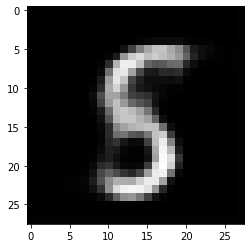

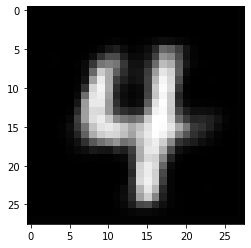

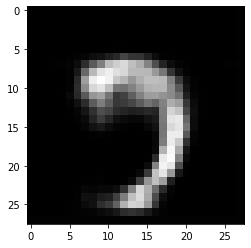

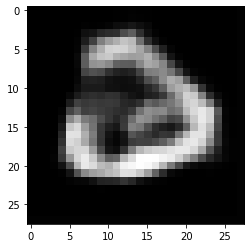

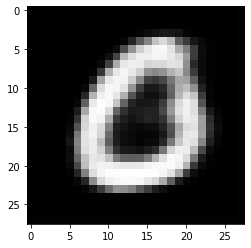

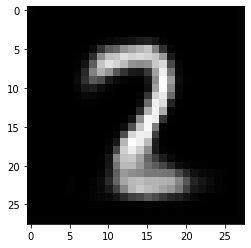

In [10]:
import matplotlib.pyplot as plt

# GENERATION
model.eval()
with torch.no_grad():
    z = torch.randn(6, latent_dim)
    pred = model.decode(z)
    #image_grid = torchvision.utils.make_grid(pred.view(-1,1,28,28), nrow=4)
    #img = torchvision.transforms.ToPILImage()(image_grid)
    #img.show()
    #img.save('vae_imgs/vae_gen.png')
    for im in pred:
        plt.imshow(im.view(28,28), cmap='gray')
        plt.show()


torch.Size([1, 28, 28])


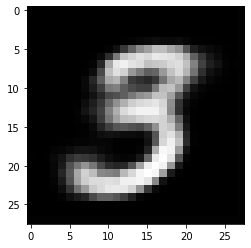

torch.Size([1, 28, 28])


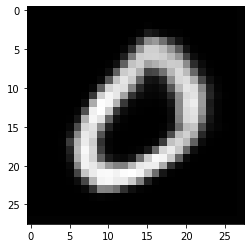

torch.Size([1, 28, 28])


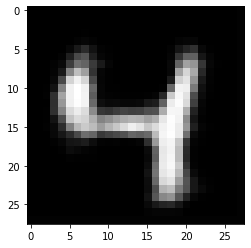

torch.Size([1, 28, 28])


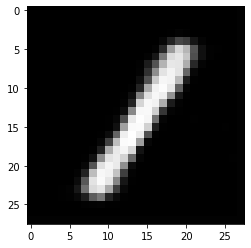

torch.Size([1, 28, 28])


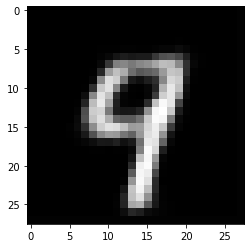

In [11]:
# RECONSTRUCTION
model.eval()
with torch.no_grad():
    i = 1
    for i in range(5):
        xb, _ = train_dl.dataset[i]
        pred = model(xb)
        print(pred[0].size())
        plt.imshow(pred[0][0], cmap='gray')
        plt.show()
        i += 1